# Final Model:
1) fill in missing in text body with empty strings 
2) column transformer for countvector maybe on title and text body 
2) Bagging classify the column tranformer to find important features 
3) pipeline

- XGBClass or Ada
- Bagging
- Random Forest
- ExtraTree

## Import Libraries

In [5]:
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import Subreddit DF's

In [6]:
df = pd.read_csv('../data/Subreddits_Data.csv', usecols = ['subreddit','selftext', 'title', 'corrected_title', 'char_count', 'word_count', 'neg', 'neu', 'pos', 'compound'])
df[['selftext', 'title', 'corrected_title']] = df[['selftext', 'title', 'corrected_title']].fillna('')

cat_col = ['corrected_title']
num_col = ['word_count', 'char_count', 'compound', 'pos', 'neu', 'neg']

In [7]:
# df[df['subreddit'] == 1] = 'explainlikeimfive'
# df[df['subreddit'] == 0] = 'NoStupidQuestions'

In [8]:
round(df['subreddit'].value_counts(normalize=True), 4)

1    0.5004
0    0.4996
Name: subreddit, dtype: float64

## Model

In [9]:
stop_words  = stopwords.words('english')
count_vec_pipe = Pipeline(
                            [
                                ('tfid', TfidfVectorizer(stop_words=stop_words + ['people', 'make'], ngram_range=(1,1))),
                                # ('vect', CountVectorizer(stop_words=stop_words, ngram_range=(1,1))),
                            ]
                        )
count_vec_pipe.fit(df['corrected_title'])
df_count_vec = pd.DataFrame(count_vec_pipe.transform(df['corrected_title']).A, columns=count_vec_pipe.get_feature_names_out())


master_df = pd.concat([df, df_count_vec], axis=1)
master_df = master_df.loc[:,~master_df.columns.duplicated()]

In [10]:
X = master_df.drop(columns=['subreddit', 'selftext', 'title', 'corrected_title'])
y = master_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

vc1 = VotingClassifier(
    [
        ('adb', AdaBoostClassifier()),
        ('boosting', xgb.XGBClassifier()),
        ('bagging', BaggingClassifier()),
        ('rfc', RandomForestClassifier()),
        ('etc', ExtraTreesClassifier()),
    ],
    weights = [.1, .1, .1, .30, .30],
    n_jobs=-1
)
ct1 = ColumnTransformer([
    ('ss', StandardScaler(), num_col), # polynomial numeric columns
], remainder = 'passthrough')
pipe = Pipeline([
    ('ct', ct1),
    ('vc1', vc1)
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['word_count', 'char_count',
                                                   'compound', 'pos', 'neu',
                                                   'neg'])])),
                ('vc1',
                 VotingClassifier(estimators=[('adb', AdaBoostClassifier()),
                                              ('boosting', XGBClassifier()),
                                              ('bagging', BaggingClassifier()),
                                              ('rfc', RandomForestClassifier()),
                                              ('etc', ExtraTreesClassifier())],
                                  n_jobs=-1,
                                  weights=[0.1, 0.1, 0.1, 0.3, 0.3]))])

## Metrics:

In [11]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(1.0, 0.8657136161237403)

In [12]:
preds = pipe.predict(X_test)


<Figure size 1080x720 with 0 Axes>

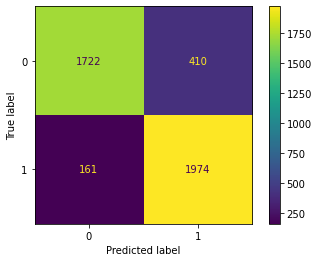

In [ ]:
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.savefig("../img/cm_final_model.png")
plt.show()

In [17]:
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
balanced_accuracy_score(y_test, preds), f1_score(y_test, preds), roc_auc_score(y_test, preds)

(0.8656669200451688, 0.8741489128047442, 0.8656669200451689)

In [ ]:
# pipe.named_steps['vc1'].named_estimators_['adb'].feature_importances_
# pipe.named_steps['vc1'].named_estimators_['boosting'].feature_importances_
# pipe.named_steps['vc1'].named_estimators_['bagging'].feature_importances_
# pipe.named_steps['vc1'].named_estimators_['rfc'].feature_importances_
# pipe.named_steps['vc1'].named_estimators_['etc'].feature_importances_
